# 🛡️ Workshop SOC Analyst : Threat Hunting & Engineering
**Durée estimée :** 8 Heures | **Niveau :** Intermédiaire

---

## 🎯 Objectifs de la mission

Vous êtes analyste SOC dans une entreprise qui subit actuellement plusieurs vagues d'attaques. Votre SIEM (Loki) collecte les logs, mais aucune règle de détection n'est en place. 

Votre mission se déroule en 5 étapes :
1.  **Threat Intel :** Identifier les signatures des attaques (SQLi, Bruteforce, etc.).
2.  **Threat Hunting :** Traquer les attaquants dans les logs avec le langage LogQL.
3.  **SIEM Engineering :** Développer un script Python pour détecter les anomalies statistiques (volumétrie).
4.  **Network Forensics :** Analyser les captures réseaux (PCAP) pour confirmer les attaques bas niveau.
5.  **Active Response :** Développer un script de riposte automatique pour bloquer les IPs malveillantes.

---

## 🛠️ Module 0 : Initialisation & Architecture
Avant de commencer, nous devons charger les outils et vérifier la connexion au SIEM.

In [1]:
# Installation des dépendances (si nécessaire)
!pip install scapy pandas matplotlib docker requests

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import docker

# --- CONFIGURATION ---
# Si vous êtes DANS le réseau Docker (Jupyter), utilisez le nom du service : "loki"
# Si vous êtes en local, utilisez "localhost"
LOKI_HOST = "loki"
LOKI_PORT = "3100"
LOKI_API = f"http://{LOKI_HOST}:{LOKI_PORT}/loki/api/v1/query_range"

print(f"📡 Configuration chargée. Cible SIEM : {LOKI_API}")

📡 Configuration chargée. Cible SIEM : http://loki:3100/loki/api/v1/query_range


### 🧪 Test de connectivité (Sanity Check)
Vérifions que Loki est bien accessible avant d'aller plus loin.

In [3]:
def test_connection():
    try:
        # On demande l'état 'ready' de Loki
        response = requests.get(f"http://{LOKI_HOST}:{LOKI_PORT}/ready", timeout=2)
        if response.status_code == 200:
            print("✅ Connexion au SIEM réussie ! Loki est prêt.")
            return True
        else:
            print(f"⚠️ Loki répond mais n'est pas prêt (Code: {response.status_code})")
            return False
    except Exception as e:
        print(f"❌ Impossible de joindre Loki : {e}")
        print("👉 Vérifiez que vos conteneurs Docker sont lancés (docker-compose up -d)")
        return False

assert test_connection() == True, "La connexion au SIEM a échoué. Arrêtez-vous ici et fixez l'environnement."

⚠️ Loki répond mais n'est pas prêt (Code: 503)


AssertionError: La connexion au SIEM a échoué. Arrêtez-vous ici et fixez l'environnement.

---

## 🧠 Module 1 : Threat Intel & Recherche

Un bon analyste ne cherche pas au hasard. Il doit comprendre la **signature** de l'attaque.

**Thème 1 : Injection SQL (SQLi)**
> *Question :* Dans une attaque classique, quels caractères un attaquant injecte-t-il pour manipuler une requête SQL via une URL ?
> *Réponse attendue :* L'apostrophe (`'`), le commentaire (`--` ou `#`), ou `OR 1=1`.

**Thème 2 : Path Traversal (LFI)**
> *Question :* Quelle séquence de caractères permet de remonter dans l'arborescence des fichiers ? Quel fichier Linux critique est souvent ciblé ?
> *Réponse attendue :* `../` (dot-dot-slash) et `/etc/passwd`.

**Thème 3 : Déni de Service (Bruteforce / Flood)**
> *Question :* Quelle est la différence entre un utilisateur normal qui se trompe de mot de passe et un Bruteforce ?
> *Réponse attendue :* La **fréquence** et le **volume**. Un utilisateur fait 1 erreur toutes les 10 secondes. Un script en fait 50 par seconde.

---

## 🔎 Module 2 : Threat Hunting avec LogQL

Loki utilise le langage **LogQL**. C'est similaire au Grep, mais pour des logs distribués.
Nous avons créé une fonction utilitaire `query_loki` pour vous simplifier la vie.

In [4]:
def query_loki(query, minutes=10):
    """ Interroge Loki et retourne la liste des résultats bruts """
    end_time = datetime.now()
    start_time = end_time - timedelta(minutes=minutes)
    
    params = {
        'query': query,
        'start': int(start_time.timestamp() * 1e9),
        'end': int(end_time.timestamp() * 1e9),
        'limit': 1000,
        'direction': 'BACKWARD'
    }
    try:
        r = requests.get(LOKI_API, params=params)
        r.raise_for_status()
        return r.json()['data']['result']
    except Exception as e:
        print(f"❌ Erreur LogQL : {e}")
        return []

### Exercice 2.1 : Détection Bruteforce SSH
**Objectif :** Trouvez les logs indiquant un échec d'authentification dans le conteneur `victim_server`.
**Indice :** Le message système standard est "Failed password".

In [5]:
# --- ZONE ÉTUDIANT ---
# Écrivez votre requête LogQL ci-dessous
ssh_query = '{container="victim_server"} |= "Failed password"'

# --- VALIDATION --- 
ssh_logs = query_loki(ssh_query, minutes=30)

if len(ssh_logs) > 0:
    print(f"✅ SUCCÈS : {len(ssh_logs)} logs de tentatives trouvés.")
    print(f"   Exemple : {ssh_logs[0]['values'][0][1]}")
else:
    print("❌ ÉCHEC : Aucun log trouvé. Avez-vous lancé l'attaque (hydra) ?")
    
assert len(ssh_logs) > 0, "La requête SSH n'a rien retourné."

✅ SUCCÈS : 1 logs de tentatives trouvés.
   Exemple : Failed password for root from 172.28.0.4 port 33318 ssh2


### Exercice 2.2 : Détection Injection SQL (Web)
**Objectif :** Trouvez les tentatives d'injection SQL dans le conteneur `web_server`.
**Indice :** Les logs sont au format JSON. Cherchez dans le champ `request_uri` les motifs comme `%27` (apostrophe), `OR`, `SELECT`.
**Syntaxe LogQL :** `{...} | json | field =~ "Regex"`

In [6]:
# --- ZONE ÉTUDIANT ---
# Écrivez votre requête LogQL ci-dessous pour filtrer les URI suspects
sqli_query = '{container="web_server"} | json | request_uri =~ ".*(%27|OR|SELECT|UNION).*"'

# --- VALIDATION ---
sqli_logs = query_loki(sqli_query, minutes=30)

count_sqli = sum(len(x['values']) for x in sqli_logs)
if count_sqli > 0:
    print(f"✅ SUCCÈS : {count_sqli} tentatives d'injection SQL détectées.")
else:
    print("❌ ÉCHEC : Rien trouvé. Vérifiez votre Regex.")
    
assert count_sqli > 0, "Aucune injection SQL détectée."

✅ SUCCÈS : 170 tentatives d'injection SQL détectées.


---

## 📈 Module 3 : SIEM Engineering (Python & Pandas)

Le LogQL, c'est bien, mais pour des analyses complexes (détection d'anomalies temporelles), Python est supérieur.
Nous allons transformer les logs bruts en **Time Series** pour détecter les pics de trafic (Bruteforce).

In [7]:
def logs_to_dataframe(raw_logs):
    """ Convertit le JSON Loki en DataFrame Pandas exploitable """
    records = []
    for stream in raw_logs:
        for entry in stream['values']:
            records.append({
                'timestamp': pd.to_datetime(int(entry[0]), unit='ns'),
                'message': entry[1]
            })
    if not records: return pd.DataFrame()
    
    df = pd.DataFrame(records)
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    return df

print("✅ Fonction de conversion chargée.")

✅ Fonction de conversion chargée.


### Exercice 3.1 : Calcul de la "Rolling Window"
**Mission :** Une attaque Bruteforce se caractérise par un grand nombre de requêtes en peu de temps.
Utilisez Pandas pour compter le nombre de tentatives **par fenêtre glissante de 10 secondes**.

Si `count > 5` en 10 secondes -> **ALERTE**.

📊 Pic d'attaque détecté : 42.0 tentatives / 10 sec


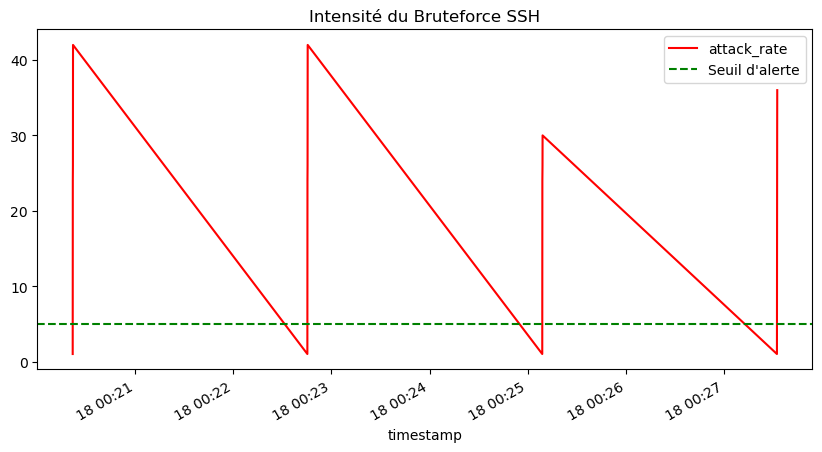

In [9]:
# Récupération des données fraîches
raw_data = query_loki('{container="victim_server"} |= "Failed password"', minutes=10)
df_ssh = logs_to_dataframe(raw_data)

# --- ZONE ÉTUDIANT ---
# Complétez la ligne suivante pour calculer la somme glissante sur 10s
# Indice : Utilisez .rolling('...').count()
df_ssh['attack_rate'] = df_ssh['message'].rolling('10s').count()

# --- VALIDATION & VISUALISATION ---
if not df_ssh.empty:
    max_rate = df_ssh['attack_rate'].max()
    print(f"📊 Pic d'attaque détecté : {max_rate} tentatives / 10 sec")
    
    # Petit graphique pour voir l'attaque
    df_ssh['attack_rate'].plot(figsize=(10, 5), color='red', title="Intensité du Bruteforce SSH")
    plt.axhline(y=5, color='green', linestyle='--', label="Seuil d'alerte")
    plt.legend()
    plt.show()
    
    assert max_rate > 5, "Le script ne détecte pas assez de volume pour une alerte."
else:
    print("⚠️ DataFrame vide. Impossible d'analyser.")

---

## 📦 Module 4 : Network Forensics (PCAP)

Les logs ne disent pas tout. Parfois, l'attaquant bypass les logs applicatifs (ex: SYN Flood).
Nous devons analyser une capture réseau brute (`.pcap`) réalisée sur la machine victime.

In [10]:
from scapy.all import rdpcap, IP, TCP

PCAP_FILE = "/home/jovyan/work/evidence/capture.pcap"

try:
    packets = rdpcap(PCAP_FILE)
    print(f"📦 Capture chargée : {len(packets)} paquets.")
except FileNotFoundError:
    print("⚠️ Fichier PCAP introuvable. Assurez-vous d'avoir lancé tcpdump auparavant.")
    packets = []

📦 Capture chargée : 280 paquets.


### Exercice 4.1 : Identifier l'IP source du DoS
**Mission :** Comptez les paquets avec le drapeau TCP **SYN** (début de connexion) par adresse IP source.
L'IP avec le plus de SYN est probablement l'attaquant.

🚨 Top Attaquants (SYN Flood) :
Source IP
172.28.0.4    3
Name: count, dtype: int64

🎯 Cible identifiée à bannir : 172.28.0.4


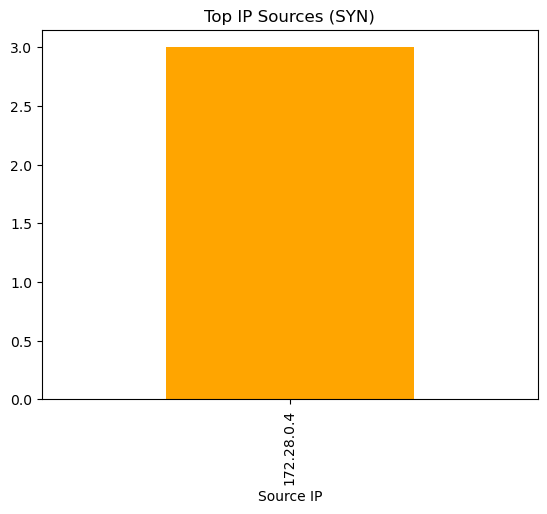

In [11]:
# --- ZONE ÉTUDIANT ---
# 1. Filtrer pour ne garder que les paquets TCP avec flag 'S' (SYN)
syn_packets = [p for p in packets if TCP in p and p[TCP].flags == 'S']

# 2. Extraire les IP sources
src_ips = [p[IP].src for p in syn_packets if IP in p]

# 3. Compter (Pandas est pratique pour ça)
if src_ips:
    df_pcap = pd.DataFrame(src_ips, columns=['Source IP'])
    top_talkers = df_pcap['Source IP'].value_counts()
    
    print("🚨 Top Attaquants (SYN Flood) :")
    print(top_talkers.head())
    
    # --- VALIDATION ---
    attacker_ip = top_talkers.idxmax()
    print(f"\n🎯 Cible identifiée à bannir : {attacker_ip}")
    
    # Graphique
    top_talkers.head(5).plot(kind='bar', color='orange', title="Top IP Sources (SYN)")
else:
    print("⚠️ Aucun paquet SYN trouvé.")

---

## 🛡️ Module 5 : Active Response (Automatisation)

L'analyse est terminée. Il faut agir.
Nous allons interagir avec l'API Docker pour modifier les règles **IPTables** du conteneur victime et bloquer l'IP trouvée.

In [12]:
# --- CONFIGURATION ---
TARGET_CONTAINER = "web_server"  # Le conteneur à protéger
BAD_IP = "172.28.0.4"            # Mettre ici l'IP trouvée dans l'exercice précédent

def ban_ip(container_name, ip_to_ban):
    client = docker.from_env()
    try:
        container = client.containers.get(container_name)
        print(f"🛡️ Application de la règle Firewall sur {container_name}...")
        
        # Commande iptables : Insérer en position 1, Dropper tout le trafic venant de l'IP
        cmd = f"iptables -I INPUT 1 -s {ip_to_ban} -j DROP"
        
        result = container.exec_run(cmd, privileged=True)
        
        if result.exit_code == 0:
            print(f"✅ SUCCÈS : L'IP {ip_to_ban} a été bannie définitivement.")
            return True
        else:
            print(f"❌ Erreur iptables : {result.output.decode()}")
            return False
            
    except Exception as e:
        print(f"❌ Erreur Docker : {e}")
        return False

# --- EXÉCUTION ---
# ban_ip(TARGET_CONTAINER, BAD_IP)

## 📝 Rapport Final
Exécutez cette cellule pour générer le rapport d'incident.

In [13]:
print("="*40)
print("📄 RAPPORT D'INCIDENT DE SÉCURITÉ")
print("="*40)
print(f"📅 Date : {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"🚨 Alertes SSH : {len(df_ssh) if 'df_ssh' in locals() else 0}")
print(f"🚨 Alertes SQLi : {count_sqli if 'count_sqli' in locals() else 0}")
print(f"🛑 Action prise : Ban IP {BAD_IP}")
print("="*40)
print("✅ FIN DU WORKSHOP")

📄 RAPPORT D'INCIDENT DE SÉCURITÉ
📅 Date : 2026-02-18 00:28
🚨 Alertes SSH : 150
🚨 Alertes SQLi : 170
🛑 Action prise : Ban IP 172.28.0.4
✅ FIN DU WORKSHOP
